In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract

In [33]:
def warp(rect, img):    
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    width = int(rect[1][0])
    height = int(rect[1][1])
    
    #הקורדינטות של האובייקט המבוקש בתוך התמונה המקורית
    src_pts = box.astype("float32")
    #הקורדינטות שיהיו בתמונת היעד - גודל התמונה הוא כגודל הלוחית שנבחרה
    dst_pts = np.array([[0, height-1],
                        [0, 0],
                        [width-1, 0],
                        [width-1, height-1]], dtype="float32")

    #פונקציה שמקבלת כקלט את הקורדינטות בתמונת המקור ואת הקורדינטות בתמונת היעד ומייצרת מטריצת טרנספורמציה שתהפוך את תמונת המקור לתמונת היעד
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)

    #פונקציה שמפעילה את מטרצת הטרנספורמציה על תמונת המקור ונותנת כפל את תמונת היעד
    warped = cv2.warpPerspective(img, M, (width, height))
    return warped

In [34]:
def pyTes(plate):
    gray = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)[1]
    custom_config = r'--oem 1 --psm 6 -c tessedit_char_whitelist=0123456789'
    return pytesseract.image_to_string(thresh, config=custom_config)

8125961



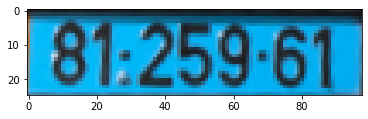

In [36]:
image = cv2.imread('IMG_6.jpg')
original = image.copy()

#המרת התמונה מתמונה מRGB לHSV
image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

#השמת ערכי HSV המתאימים לצבע צהוב
lower = np.array([16, 120, 0], dtype="uint8")
upper = np.array([24, 255, 255], dtype="uint8")

#הפיכת התמונה לתמונה בינארית כך שערכי הצהוב ייצבעו בלבן והשאר בשחור על פי שימוש בערכי HSV הנ"ל
mask = cv2.inRange(image, lower, upper)

#מציאת העצמים הקיימים בתמונה
cnts = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]

plates = []
plate_num = []

#השמת גודל התמונה שישמש לבחינת היחס בין גודל הלוחית ובין גודל התמונה עצמה
img_size = image.shape[0] * image.shape[1]

for c in cnts:
    #פונקציה המוצאת את המלבן המינימאלי מסביב לעצם מסוים בתמונה, הפונקציה מחזירה מבנה שיש בו קורדינטת מרכז גובה ורוחב של המלבן וזווית ההטיה
    rect = cv2.minAreaRect(c)
    #פונקציה שמקבלת את נתוני צורת המלבן ומחזירה קורדינטות של ארבע נקודות המלבן
    box = cv2.boxPoints(rect) 
    box = np.int0(box)
    #בדיקת היחס בין הקורדינטות של המלבן - מפורט במסמך המצורף
    if box[1][0] < box[3][0]: 
        w = int(rect[1][0])
        h = int(rect[1][1])
    else:
        h = int(rect[1][0])
        w = int(rect[1][1])
    #סינון האובייקטים בתמונה לפי גודל האובייקט ולפי היחס בין הגובה לאורך
    if w > h * 3 and w < h *5.5 and h*w  > img_size / 1000 and h*w < img_size / 10:
        #פונקציה שמיישרת את הלוחית המוטית
        warped = warp(rect, original)
        #במקרה שהיישור יישר את הלוחית בצורה אנכית, נהפוך את הלוחית כך שתהיה אופקית
        if (warped.shape[0] > warped.shape[1]):
            warped = cv2.rotate(warped, cv2.cv2.ROTATE_90_CLOCKWISE)
        plates.append(warped)

#הצגת הלוחיות שנמצאות בתמונה
for plate in plates:
    plt.imshow(plate)
    print(pyTes(plate))